In [1]:
#load packages

import math, time
import torch
import os
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#CHOOSE DATA PATH AND NAME
DATA_PATH = './data/' #change this to your data path
dataname = '2dgaussian_diffmag' #change this to your data name

In [ ]:
#load data subset
from functions.get_data import data_n_loaders
# LAB_DIR = os.environ['USERDIR']
# DATA_PATH = LAB_DIR+'/data'

batch_size = 512
_, _,train_data, _, mean, scale = data_n_loaders(dataname, batch_size, return_data=True, \
      data_path=DATA_PATH, standardise_data = True, return_transform=True)
mean = mean.squeeze()
train_data_raw = (train_data.data/scale) + mean


#sample equal number of points from each concept
torch.manual_seed(0)
numpoints_perconcept = 1000
num_concepts = 6
data_subset_perconcept = []
labels_subset_perconcept = []
for i in range(num_concepts):
    indices = train_data.labels == i
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data_raw[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset_raw = torch.cat(data_subset_perconcept, dim=0)
data_subset = (data_subset_raw - mean) * scale #transform same as training data (to input to model)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)
datavar = data_subset.var(dim=0).sum().item()
mean_norm2_data = (data_subset**2).sum(dim=-1).mean().item()
datavar_perconc = torch.tensor([data_subset[labels_subset==i,:].var(dim=0).sum().item() for i in range(num_concepts)])
mean_norm2_data_perconc = torch.tensor([(data_subset[labels_subset==i,:]**2).sum(dim=-1).mean().item() for i in range(num_concepts)])

/n/home00/sumedh/spmax_sae/experiments/expt19_separability_diffmag2/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)

In [ ]:
#choose models to visualize

#get exptnames from folder names within saved_models
exptnames = []
for root, dirs, files in os.walk('saved_models'):
    for dir in dirs:
        if 'checkpoints_' in dir:
            if ('gamreg' not in dir and 'topk' not in dir) or 'k15' in dir:
                continue
            if 'w128' not in dir:
                continue
            exptnames.append(dir.split('checkpoints_')[1])
#sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
order = {'relu': 0, 'jumprelu': 1, 'topk': 2, 'spade': 3}
exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))

#get parameters from expt_names
saetypes = []
for exptname in exptnames:
    if 'spade' in exptname:
        saetypes.append('sparsemax_dist')
    elif 'topk_relu' in exptname:
        saetypes.append('topk_relu')
    else:
        saetypes.append(exptname.split('_')[1])
kvals_all = []
for exptname in exptnames:
    if 'topk' in exptname:
        kvals_all.append(int(exptname.split('_k')[1].split('_')[0]))
    else:
        kvals_all.append(0)
gammavals_all = []
for exptname in exptnames:
    if 'gamreg' in exptname:
        gammavals_all.append(float(exptname.split('_gamreg')[1].split('_')[0]))
    else:
        gammavals_all.append(0)
max_iters = []
for exptname in exptnames:
    epochs = []
    for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
        for file in files:
            if 'model_' in file:
                epochs.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
    max_iters.append(max(epochs))
iters_all = []
for exptname in exptnames:
    iters = []
    for root, dirs, files in os.walk('saved_models/checkpoints_'+exptname):
        for file in files:
            if 'model_' in file:
                iters.append(int(file.split('_')[1].split('.pt')[0].split('epochs')[0]))
    iters_all.append(iters)

#choose which models (hyperparams) to plot
kvals_plot = [2*i for i in range(1, 11)]
gammavals_relu_plot = [1.0, 0.5, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06, 1e-06]
gammavals_jumprelu_plot = [0.1, 0.05, 0.005, 0.00125, 0.001, 0.0005, 0.0001, 5e-05, 1e-05, 5e-06]
gammavals_spade_plot = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]
relu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'relu' and gammavals_all[i] in gammavals_relu_plot]
jumprelu_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu' and gammavals_all[i] in gammavals_jumprelu_plot]
topk_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu' and kvals_all[i] in kvals_plot]
spade_indices2 = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist' and gammavals_all[i] in gammavals_spade_plot]
numpoints_persae = len(relu_indices2)
allindices2 = relu_indices2 + jumprelu_indices2 + topk_indices2 + spade_indices2
exptnames = [exptnames[i] for i in allindices2]
saetypes = [saetypes[i] for i in allindices2]
kvals_all = [kvals_all[i] for i in allindices2]
gammavals_all = [gammavals_all[i] for i in allindices2]
max_iters = [max_iters[i] for i in allindices2]
iters_all = [sorted(iters_all[i]) for i in allindices2]
assert len(set(max_iters))==1 #max-iters same for all models

In [ ]:
#load trained models for chosen hyperparams
from models import SAE
width = 128 #of sae
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mse_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
mse_perconcept_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
mse_center_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
dimdata = 2
l0_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
numdead_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
l0_perconc_all = [[None for i in range(len(iters_all[j]))] for j in range(len(exptnames))]
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True

    #load model checkpoints during training
    for j in range(len(iters_all[i])):
        modelij = SAE(dimdata, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
        state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{iters_all[i][j]}epochs.pt")
        modelij.load_state_dict(state_dict['model'])
        modelij = modelij.to(device)
        with torch.no_grad():
            pts_recon, latent_reps = modelij(data_subset.to(device), return_hidden=True)
            mse = ((pts_recon - data_subset.to(device))**2).sum(dim=-1).mean().item()
            mse_all[i][j]= mse
            l0_all[i][j] = (latent_reps > 1e-12).sum(dim=-1).float().mean().item()
            numdead_all[i][j] = (latent_reps.sum(dim=0) < 1e-8).sum().float().item()
            mseperconc = []
            mse_center = []
            l0_perconc = []
            for k in range(num_concepts):
                indices = labels_subset == k
                mseperconc.append(((pts_recon[indices] - data_subset[indices].to(device))**2).sum(dim=-1).mean().item())
                mse_center.append(((pts_recon[indices] - data_subset[indices].mean(dim=0, keepdim=True).to(device))**2).sum(dim=-1).mean().item())
                l0_perconc.append((latent_reps[indices] > 1e-12).sum(dim=-1).float().mean().item())
            l0_perconc_all[i][j] = l0_perconc
            mse_perconcept_all[i][j] = mseperconc
            mse_center_all[i][j] = mse_center
    print(f"expt {i} done")

/tmp/ipykernel_3644927/3505797555.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_{iters_all[i][j

expt 0 done
expt 1 done
expt 2 done
expt 3 done
expt 4 done
expt 5 done
expt 6 done
expt 7 done
expt 8 done
expt 9 done
expt 10 done
expt 11 done
expt 12 done
expt 13 done
expt 14 done
expt 15 done
expt 16 done
expt 17 done
expt 18 done
expt 19 done
expt 20 done
expt 21 done
expt 22 done
expt 23 done
expt 24 done
expt 25 done
expt 26 done
expt 27 done
expt 28 done
expt 29 done
expt 30 done
expt 31 done
expt 32 done
expt 33 done
expt 34 done
expt 35 done
expt 36 done
expt 37 done
expt 38 done
expt 39 done


In [5]:
relu_indices = [i for i in range(len(exptnames)) if saetypes[i] == 'relu']
jumprelu_indices = [i for i in range(len(exptnames)) if saetypes[i] == 'jumprelu']
topk_indices = [i for i in range(len(exptnames)) if saetypes[i] == 'topk_relu']
spade_indices = [i for i in range(len(exptnames)) if saetypes[i] == 'sparsemax_dist']

In [6]:
indices_saesall = [relu_indices, jumprelu_indices, topk_indices, spade_indices]

In [7]:
saes_order = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']
saenames_plot = ['ReLU', 'JumpReLU', 'TopK', 'SpaDE']
colors_sae = ['#A2E634', '#3B81F6', '#FDE046', '#8B5CF7']

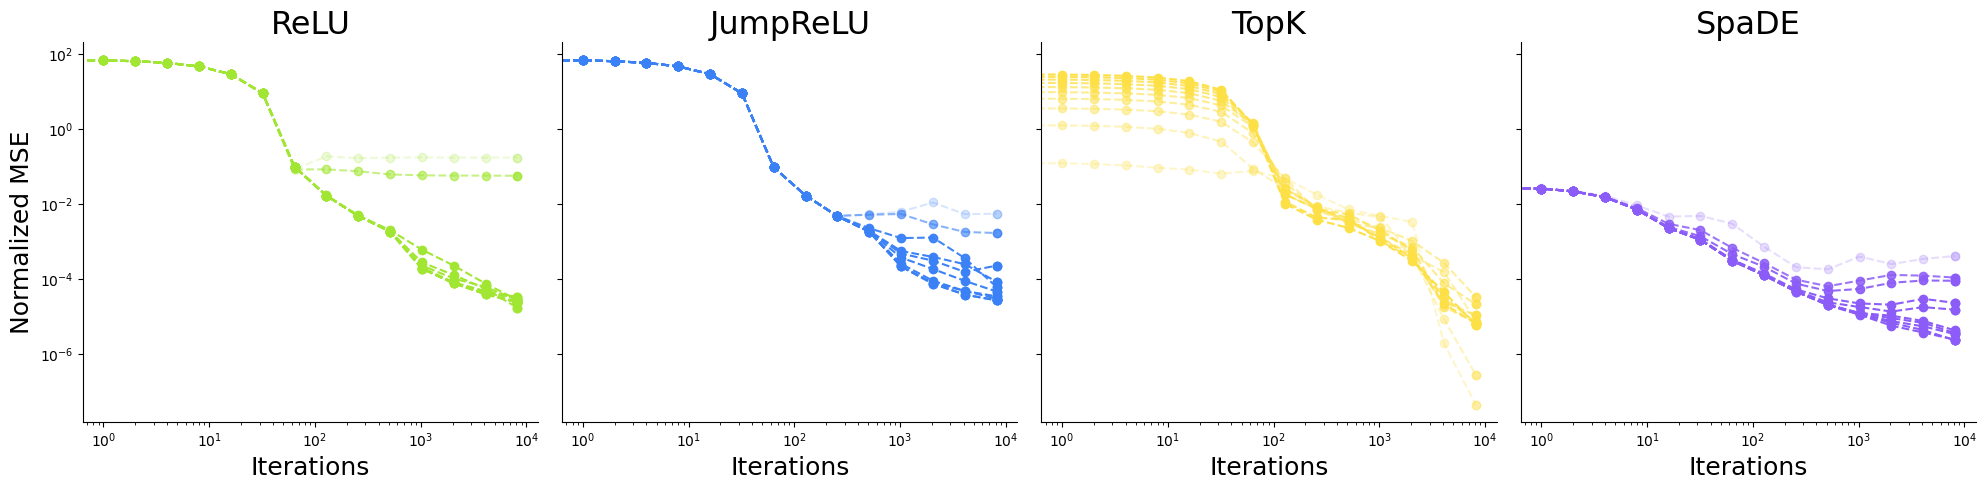

In [ ]:
#plot normalized MSE vs training iterations for each SAE
fig, ax = plt.subplots(1, 4, figsize=(5*4, 5*1), sharey=True)

for i in range(len(saes_order)):
    indices_saei = indices_saesall[i] #all gamma values for this sae
    for j in range(len(indices_saei)):
        if saetypes[indices_saei[j]] != 'topk_relu':
            gij = gammavals_all[indices_saei[j]]
            gmax = max(torch.tensor(gammavals_all)[indices_saei]).item()
            alphaval =0.2 + 0.8*(1- gij/gmax)
        else:
            kij = kvals_all[indices_saei[j]]
            kmax = max(torch.tensor(kvals_all)[indices_saei]).item()
            alphaval = 0.2 + 0.8*(kij/kmax)
        # alphaval = 1
        ax[i].plot(iters_all[indices_saei[j]], torch.tensor(mse_all[indices_saei[j]])/datavar, c=colors_sae[i], \
            alpha=alphaval, marker='o', linestyle='dashed')
        if j==0:
            ax[i].set_title(saenames_plot[i], fontsize=23)
            ax[i].set_xlabel('Iterations', fontsize=18)
        if i==0:
            ax[i].set_ylabel('Normalized MSE', fontsize=18)
        ax[i].set_yscale('log')
        ax[i].set_xscale('log')
for axis in ax:
    # axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

plt.tight_layout()
# plt.savefig('./figs/appendix_sep_msevsitersallsae.pdf', dpi=300, bbox_inches='tight')

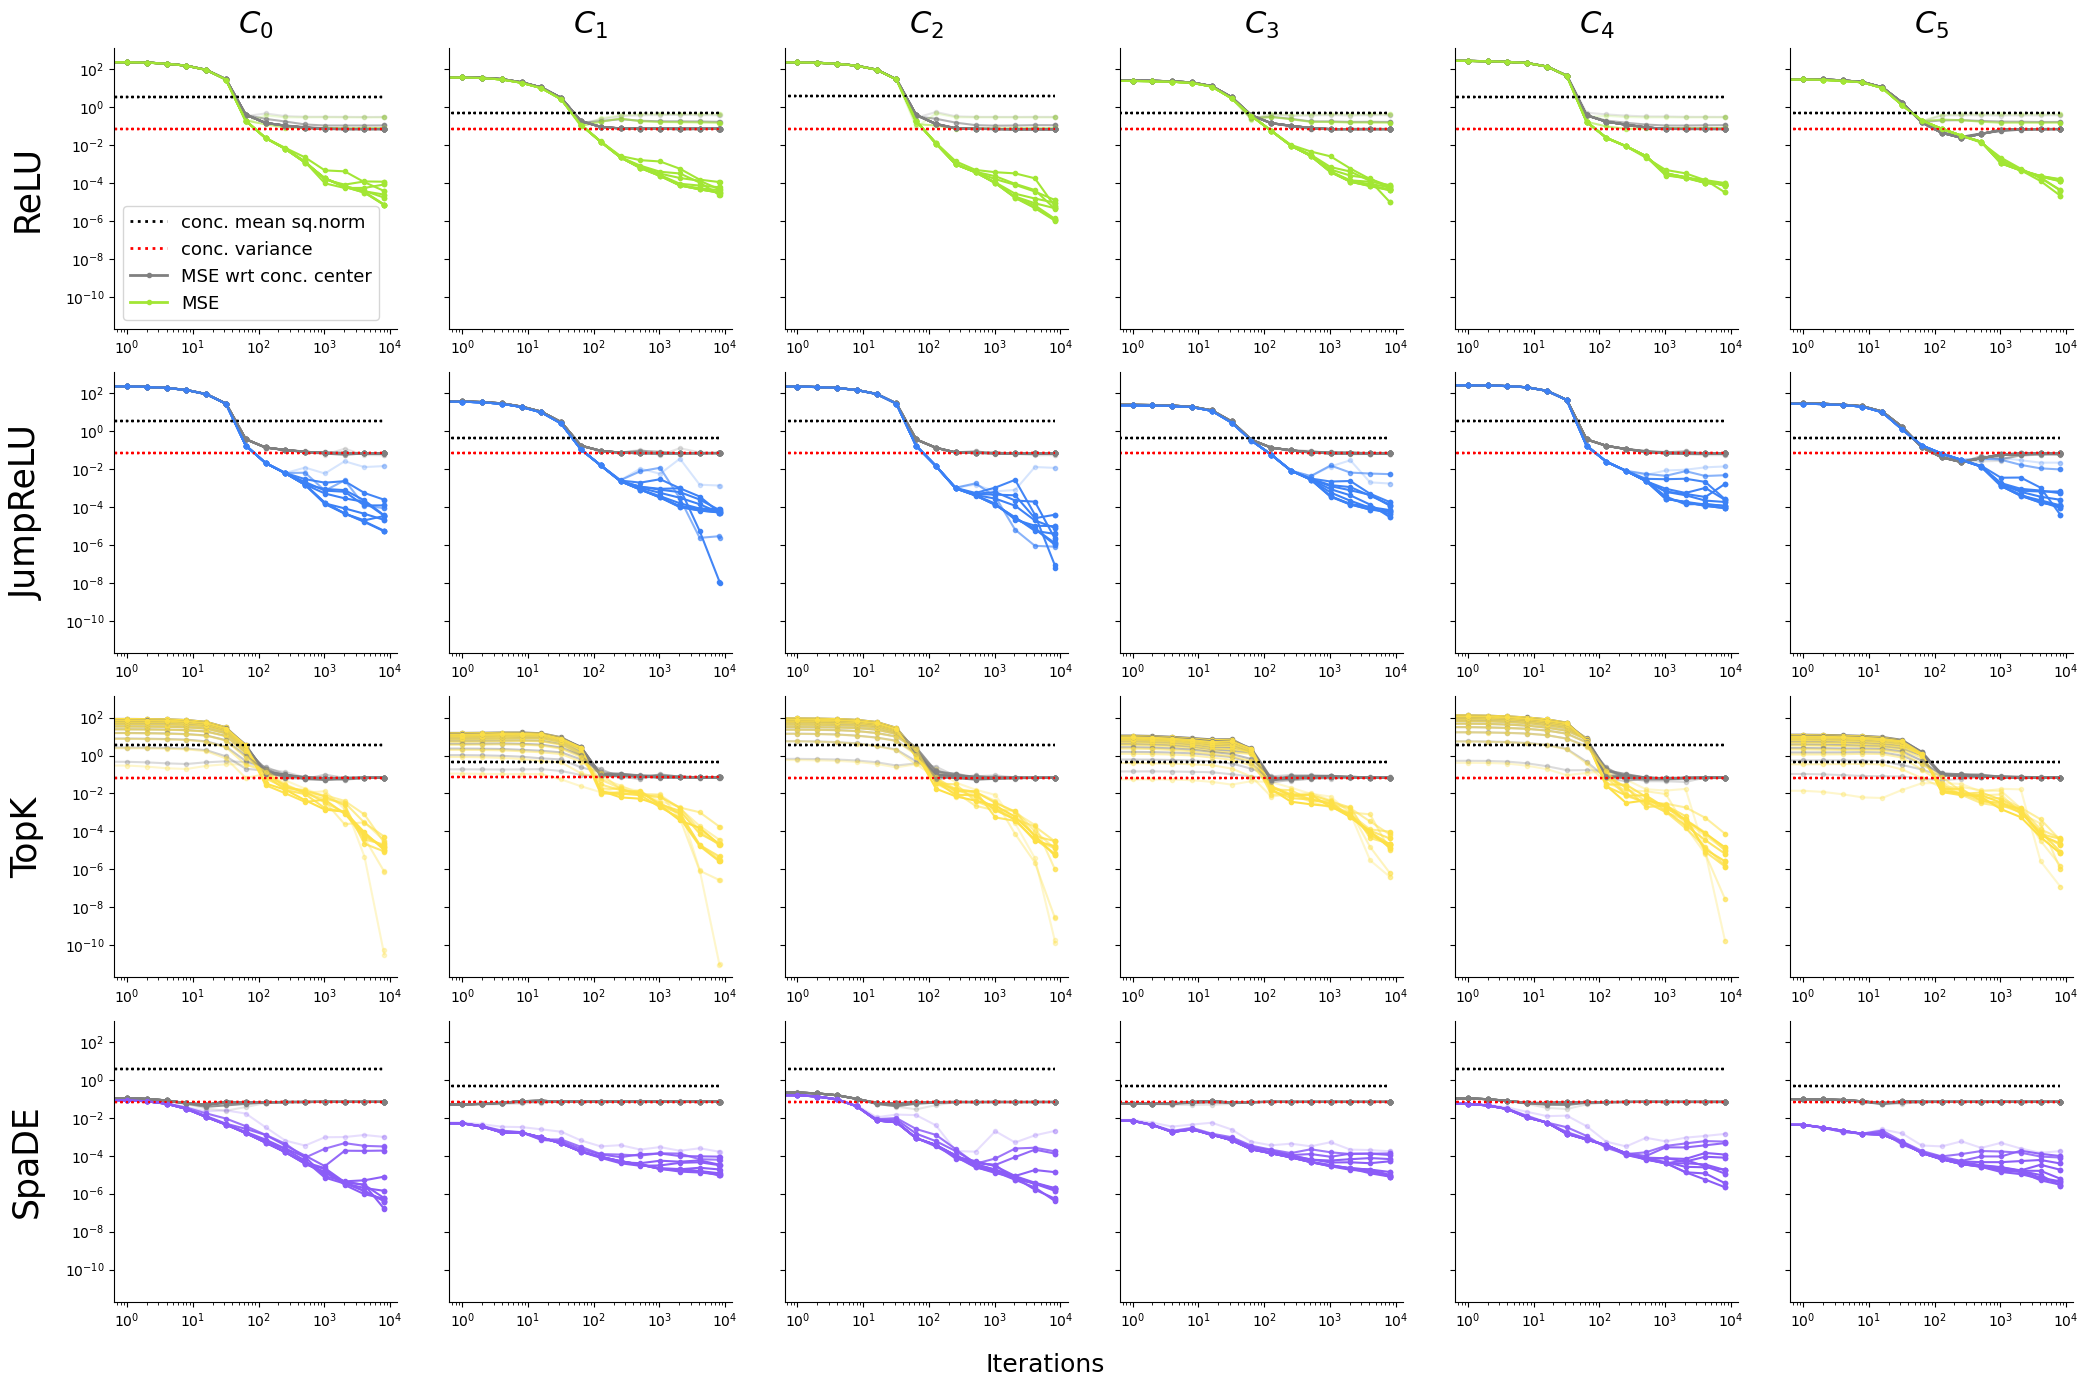

In [ ]:
#plot MSE, MSE wrt center, mean sq. norm of data, variance of data for each concept
fig, ax = plt.subplots(4, num_concepts, figsize=(3*7, 3*4.5), sharey=True)

for i in range(len(saes_order)): #for each sae type
    indices_saei = indices_saesall[i] #all gamma values for this sae
    for j in range(len(indices_saei)): #for each gamma value of this sae
        for k in range(num_concepts): #for each concept
            if saetypes[indices_saei[j]] != 'topk_relu':
                gij = gammavals_all[indices_saei[j]]
                gmax = max(torch.tensor(gammavals_all)[indices_saei]).item()
                alphaval =0.2 + 0.8*(1- gij/gmax)
            else:
                kij = kvals_all[indices_saei[j]]
                kmax = max(torch.tensor(kvals_all)[indices_saei]).item()
                alphaval = 0.2 + 0.8*(kij/kmax)
            mse_perconc = torch.tensor(mse_perconcept_all[indices_saei[j]])[:,k]
            mse_center = torch.tensor(mse_center_all[indices_saei[j]])[:,k]
            ax[i, k].plot(iters_all[indices_saei[j]], mse_center, c='gray', \
                alpha=alphaval, marker='.', linestyle='solid')
            ax[i, k].plot(iters_all[indices_saei[j]], mse_perconc, c=colors_sae[i], \
                alpha=alphaval, marker='.', linestyle='solid')
            
            ax[i, k].hlines(mean_norm2_data_perconc[k], 0, max_iters[indices_saei[j]], color='black', linestyle='dotted')
            ax[i, k].hlines(datavar_perconc[k], 0, max_iters[indices_saei[j]], color='r', linestyle='dotted')
            
            if j==0 and i==0:
                ax[i, k].set_title(f"$C_{k}$", fontsize=22, pad=10)
                # ax[i, k].set_xlabel('Iterations', fontsize=15)
            if k==0:
                ax[i, k].set_ylabel(saenames_plot[i], fontsize=25, labelpad=15)
            ax[i,k].set_yscale('log')
            ax[i,k].set_xscale('log')
for axis in ax.flatten():
    # axis.grid()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
#add custom legend to ax[0,0], show the black dotted line, red dotted line, a gray line and a colored line
ax[0,0].plot([], [], color='black', linestyle='dotted', label='conc. mean sq.norm', linewidth=2)
ax[0,0].plot([], [], color='r', linestyle='dotted', label='conc. variance', linewidth=2)
ax[0,0].plot([], [], color='gray',marker='.', linestyle='solid', label='MSE wrt conc. center', linewidth=2)
ax[0,0].plot([], [], color=colors_sae[0], marker='.', linestyle='solid', label='MSE', linewidth=2)
ax[0,0].legend(loc='lower left', fontsize=13)
ax[0,0]

fig.text(0.5, -0.02, 'Iterations', ha='center', fontsize=18)

plt.tight_layout()
# plt.savefig('./figs/appendix_sep_msedynamics.pdf', bbox_inches='tight', dpi=300)